### DeepLIFT based model Explaination

In [ ]:
%tensorflow_version 1.x


TensorFlow 1.x selected.


In [ ]:
! pip install deeplift

  Created wheel for deeplift: filename=deeplift-0.6.13.0-cp37-none-any.whl size=36447 sha256=f3a8f82015e5a20d2a18fe0b45bb4ae3d6421681df4b4a383d0a9df78ad246a6
  Stored in directory: /root/.cache/pip/wheels/39/a2/1b/a2eac3afbfedc4fb40e213ec4f8d97d26598325f187ae0dc5a
Successfully built deeplift


In [ ]:
# import the required libraries
import deeplift
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.models import load_model
from deeplift.layers import NonlinearMxtsMode
import deeplift.conversion.kerasapi_conversion as kc
from collections import OrderedDict
from keras.models import model_from_json

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [ ]:
print("Tensorflow version:", tf.__version__)
import keras
print("Keras version:", keras.__version__)
import numpy
print("Numpy version:", numpy.__version__)

Tensorflow version: 1.15.2
Keras version: 2.3.1
Numpy version: 1.19.5


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the dataset
data = pd.read_csv("/content/drive/MyDrive/data_all_dfeatures.csv")

In [ ]:
# Importing test_train_split from sklearn library
from sklearn.model_selection import train_test_split
# get the predictors and target variable from dataset
X = data.drop('readmitted', axis=1)
y = data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101, stratify=y)


In [ ]:
# load the keras model

keras_model_weights = "/content/drive/MyDrive/modelling_save/mlp_weights_alldfeatures.h5"
keras_model_json = "/content/drive/MyDrive/modelling_save/mlp_json_all_dfeatures.json"

keras_model = open(keras_model_json, 'r').read()
#keras_model = load_model("/content/drive/MyDrive/modelling_save/mlp_all_dfeatures")
keras_model = model_from_json(keras_model)
keras_model.load_weights(keras_model_weights)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# Prepare the deeplift model
method_to_model = OrderedDict()
for method_name, nonlinear_mxts_mode in [
    ('rescale_all_layers', NonlinearMxtsMode.Rescale),
    ('revealcancel_all_layers', NonlinearMxtsMode.RevealCancel),
    ('grad_times_inp', NonlinearMxtsMode.Gradient),
    ('guided_backprop', NonlinearMxtsMode.GuidedBackprop)]:
    method_to_model[method_name] = kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json,
        nonlinear_mxts_mode=nonlinear_mxts_mode)


nonlinear_mxts_mode is set to: Rescale

nonlinear_mxts_mode is set to: RevealCancel


/usr/local/lib/python3.7/dist-packages/deeplift/conversion/kerasapi_conversion.py:366: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  model_weights = h5py.File(h5_file)


nonlinear_mxts_mode is set to: Gradient
nonlinear_mxts_mode is set to: GuidedBackprop


In [ ]:
# make sure predictions are the same as the original model
from deeplift.util import compile_func
import numpy as np
model_to_test = method_to_model['revealcancel_all_layers']
deeplift_prediction_func = compile_func([model_to_test.get_layers()[0].get_activation_vars()],
                                         model_to_test.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(X_test, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[X_test],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("maximum difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
#assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions


maximum difference in predictions: 0.00018164515


In [ ]:
print("Compiling scoring functions")
method_to_scoring_func = OrderedDict()
for method,model in method_to_model.items():
    print("Compiling scoring function for: "+method)
    method_to_scoring_func[method] = model.get_target_contribs_func(find_scores_layer_idx=0,
                                                                    target_layer_idx=-2)
    
# To get a function that just gives the gradients, we use the multipliers of the Gradient model
gradient_func = method_to_model['grad_times_inp'].get_target_multipliers_func(find_scores_layer_idx=0,
                                                                              target_layer_idx=-2)
print("Compiling integrated gradients scoring functions")
integrated_gradients10_func = deeplift.util.get_integrated_gradients_function(
    gradient_computation_function = gradient_func,
    num_intervals=10)
method_to_scoring_func['integrated_gradients10'] = integrated_gradients10_func

Compiling scoring functions
Compiling scoring function for: rescale_all_layers



Compiling scoring function for: revealcancel_all_layers
Compiling scoring function for: grad_times_inp
Compiling scoring function for: guided_backprop
Compiling integrated gradients scoring functions


In [ ]:
X_test1 = np.array(X_test)

# X_test2 = X_test1[:, None]
X_test1

array([[ 0., 45.,  1., ...,  0.,  0.,  0.],
       [ 1., 65.,  1., ...,  0.,  0.,  0.],
       [ 0., 65.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 1., 75.,  1., ...,  0.,  0.,  0.],
       [ 0., 65.,  1., ...,  0.,  0.,  0.],
       [ 0., 55.,  1., ...,  0.,  0.,  0.]])

In [ ]:
X_test1.shape

(19868, 130)

In [ ]:
from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
# select a set of background examples to take an expectation over
#background = X_train.iloc[np.random.choice(X_train.shape[0], 100, replace=False)]

for method_name, score_func in method_to_scoring_func.items():
    print("on method",method_name)
    method_to_task_to_scores[method_name] = OrderedDict()
    for task_idx in [0]:
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[X_test1],
                    # input_references_list=[np.array([)[None,None,:]],
                    input_references_list=[np.zeros_like(X_test1)],
                    batch_size=200,
                    progress_update=None))
        #The sum over the ACGT axis in the code below is important! Recall that DeepLIFT
        # assigns contributions based on difference-from-reference; if
        # a position is [1,0,0,0] (i.e. 'A') in the actual sequence and [0.3, 0.2, 0.2, 0.3]
        # in the reference, importance will be assigned to the difference (1-0.3)
        # in the 'A' channel, (0-0.2) in the 'C' channel,
        # (0-0.2) in the G channel, and (0-0.3) in the T channel. You want to take the importance
        # on all four channels and sum them up, so that at visualization-time you can project the
        # total importance over all four channels onto the base that is actually present (i.e. the 'A'). If you
        # don't do this, your visualization will look very confusing as multiple bases will be highlighted at
        # every position and you won't know which base is the one that is actually present in the sequence!
        scores = np.sum(scores, axis=1)
        method_to_task_to_scores[method_name][task_idx] = scores

on method rescale_all_layers
on method revealcancel_all_layers
on method grad_times_inp
on method guided_backprop
on method integrated_gradients10


Scores for task 0 for example 123


grad_times_inp


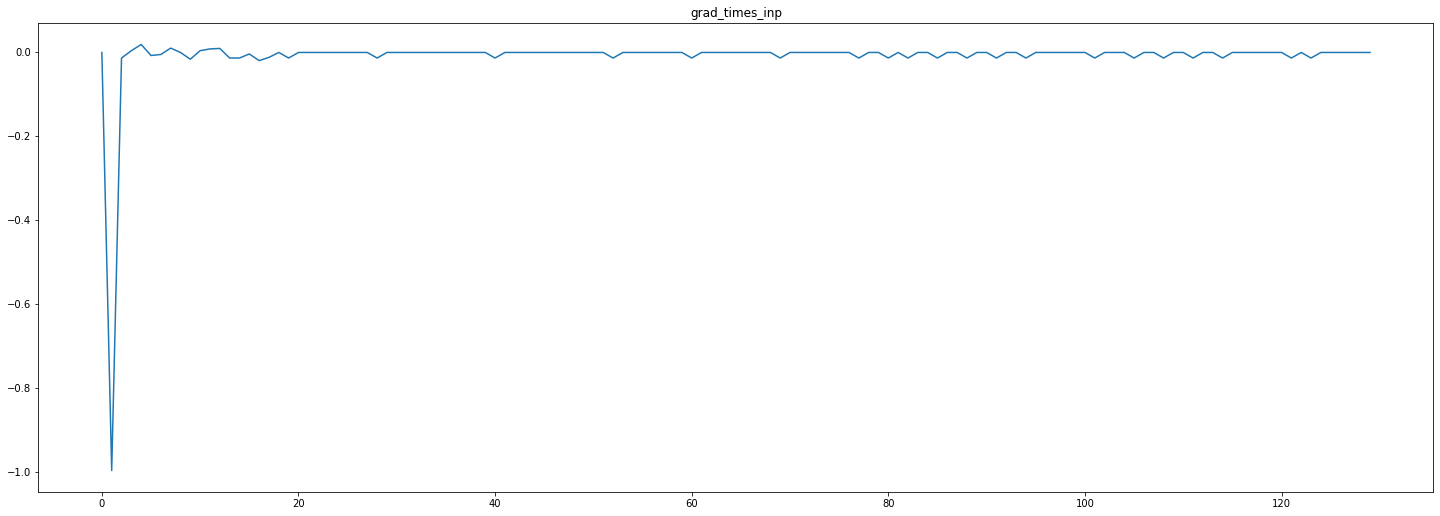

Top 20 fetaures for  grad_times_inp
featutre index: 4  feature Score: 0.01902766519248057 featutre index: 7  feature Score: 0.010418015886317758 featutre index: 12  feature Score: 0.009602164098278437 featutre index: 11  feature Score: 0.008445765026788368 featutre index: 10  feature Score: 0.004295042623267443 featutre index: 3  feature Score: 0.004223488862392903 featutre index: 129  feature Score: -0.0 featutre index: 50  feature Score: -0.0 featutre index: 55  feature Score: -0.0 featutre index: 54  feature Score: -0.0 featutre index: 53  feature Score: -0.0 featutre index: 51  feature Score: -0.0 featutre index: 47  feature Score: -0.0 featutre index: 49  feature Score: -0.0 featutre index: 48  feature Score: -0.0 featutre index: 57  feature Score: -0.0 featutre index: 46  feature Score: -0.0 featutre index: 56  feature Score: -0.0 featutre index: 62  feature Score: -0.0 


guided_backprop


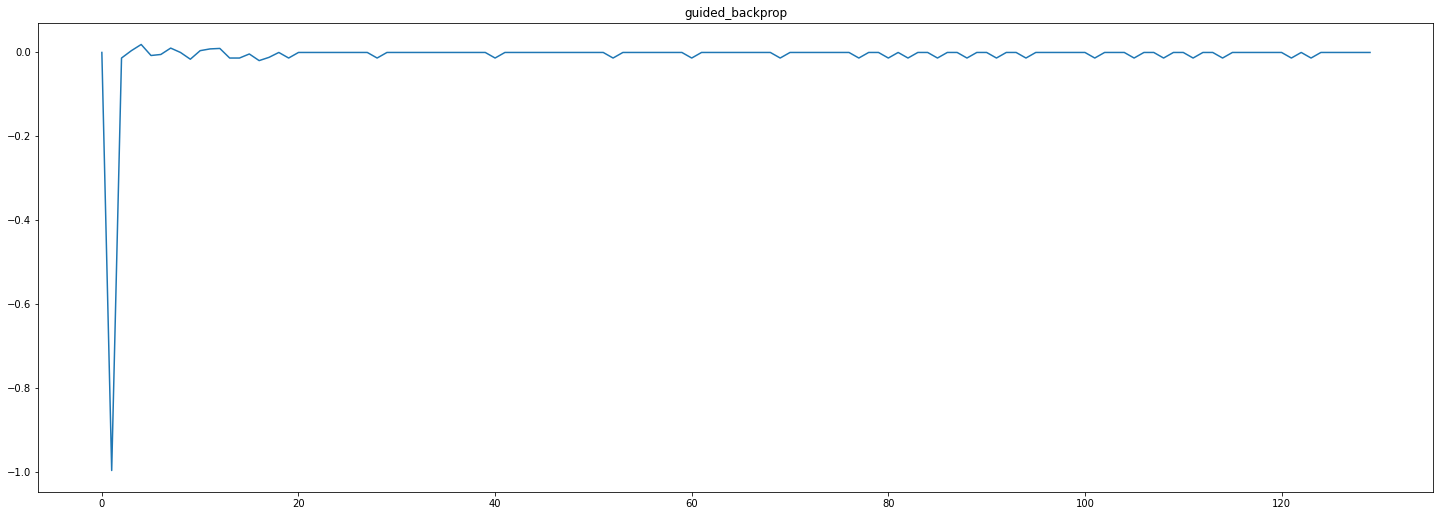

Top 20 fetaures for  guided_backprop
featutre index: 4  feature Score: 0.01902766519248057 featutre index: 7  feature Score: 0.010418015886317758 featutre index: 12  feature Score: 0.009602164098278437 featutre index: 11  feature Score: 0.008445765026788368 featutre index: 10  feature Score: 0.004295042623267443 featutre index: 3  feature Score: 0.004223488862392904 featutre index: 129  feature Score: -0.0 featutre index: 50  feature Score: -0.0 featutre index: 55  feature Score: -0.0 featutre index: 54  feature Score: -0.0 featutre index: 53  feature Score: -0.0 featutre index: 51  feature Score: -0.0 featutre index: 47  feature Score: -0.0 featutre index: 49  feature Score: -0.0 featutre index: 48  feature Score: -0.0 featutre index: 57  feature Score: -0.0 featutre index: 46  feature Score: -0.0 featutre index: 56  feature Score: -0.0 featutre index: 62  feature Score: -0.0 


integrated_gradients10


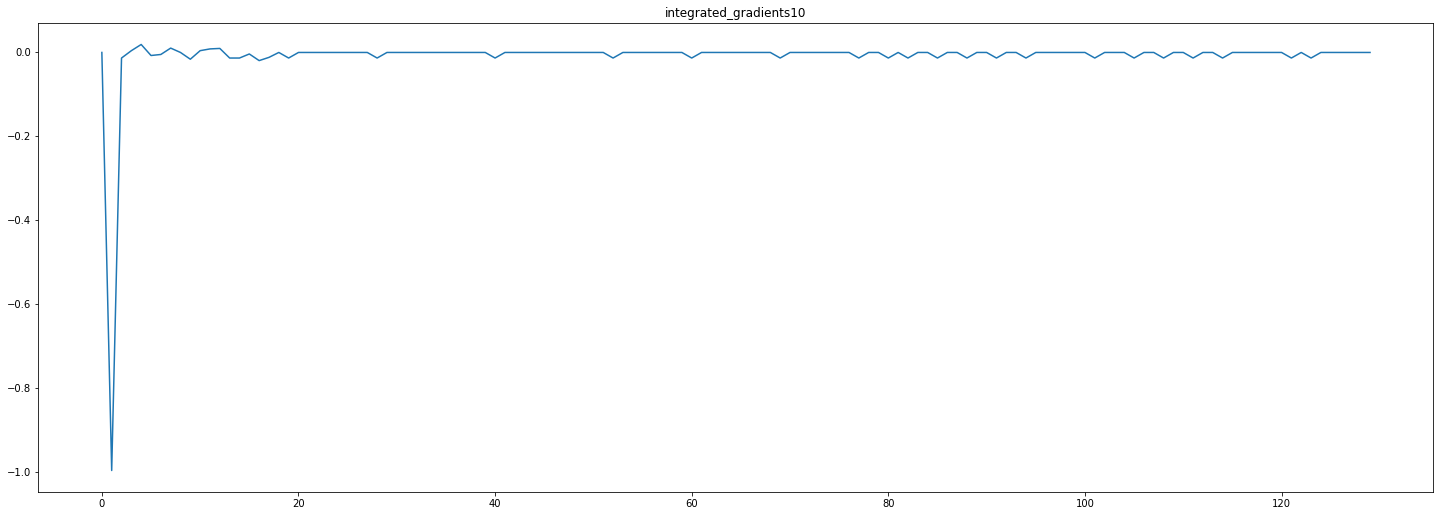

Top 20 fetaures for  integrated_gradients10
featutre index: 4  feature Score: 0.019027665192480572 featutre index: 7  feature Score: 0.01041801588631776 featutre index: 12  feature Score: 0.009602164098278437 featutre index: 11  feature Score: 0.00844576502678837 featutre index: 10  feature Score: 0.004295042623267443 featutre index: 3  feature Score: 0.004223488862392904 featutre index: 129  feature Score: -0.0 featutre index: 50  feature Score: -0.0 featutre index: 55  feature Score: -0.0 featutre index: 54  feature Score: -0.0 featutre index: 53  feature Score: -0.0 featutre index: 51  feature Score: -0.0 featutre index: 47  feature Score: -0.0 featutre index: 49  feature Score: -0.0 featutre index: 48  feature Score: -0.0 featutre index: 57  feature Score: -0.0 featutre index: 46  feature Score: -0.0 featutre index: 56  feature Score: -0.0 featutre index: 62  feature Score: -0.0 


rescale_all_layers


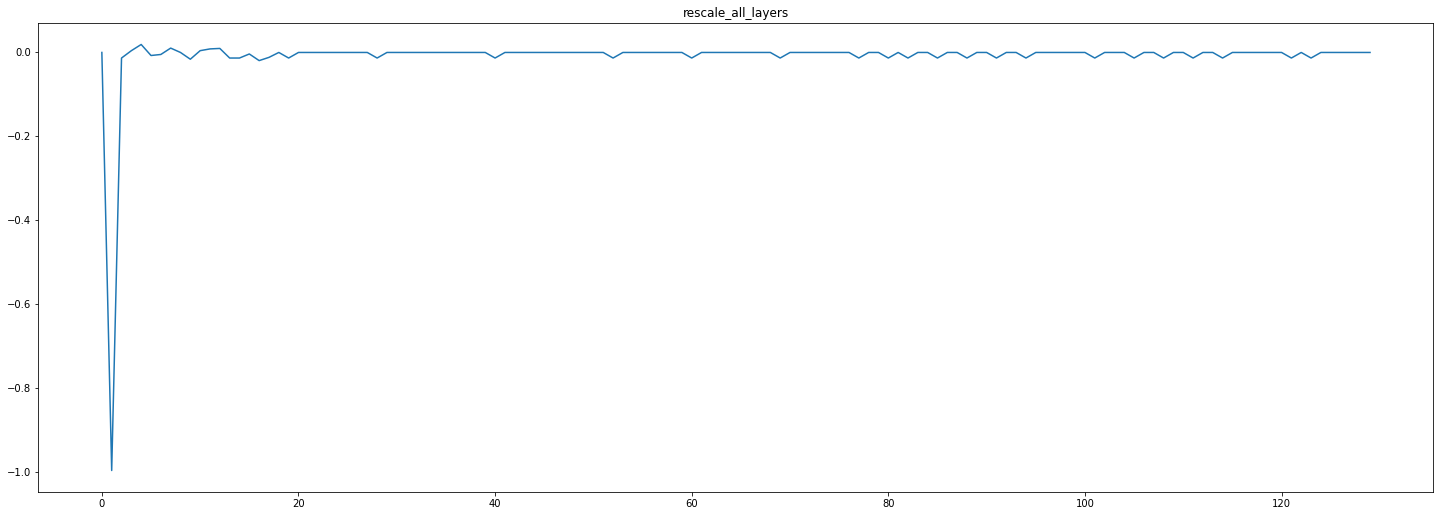

Top 20 fetaures for  rescale_all_layers
featutre index: 4  feature Score: 0.01902766519248057 featutre index: 7  feature Score: 0.010418015886317758 featutre index: 12  feature Score: 0.009602164098278437 featutre index: 11  feature Score: 0.008445765026788368 featutre index: 10  feature Score: 0.004295042623267443 featutre index: 3  feature Score: 0.004223488862392903 featutre index: 129  feature Score: -0.0 featutre index: 50  feature Score: -0.0 featutre index: 55  feature Score: -0.0 featutre index: 54  feature Score: -0.0 featutre index: 53  feature Score: -0.0 featutre index: 51  feature Score: -0.0 featutre index: 47  feature Score: -0.0 featutre index: 49  feature Score: -0.0 featutre index: 48  feature Score: -0.0 featutre index: 57  feature Score: -0.0 featutre index: 46  feature Score: -0.0 featutre index: 56  feature Score: -0.0 featutre index: 62  feature Score: -0.0 


revealcancel_all_layers


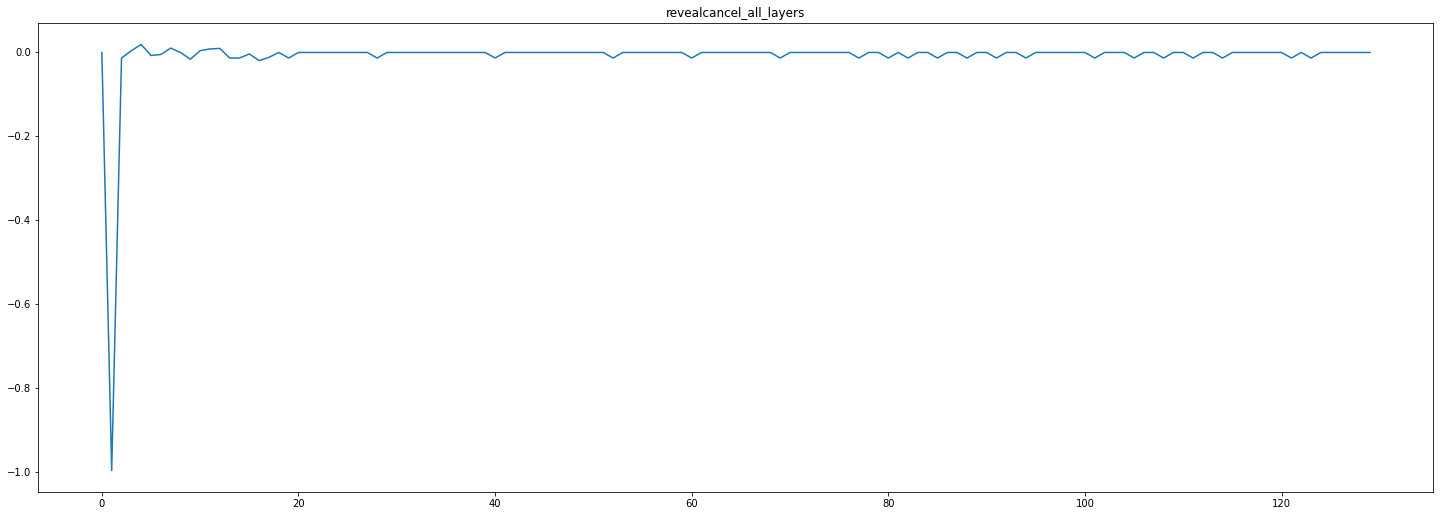

Top 20 fetaures for  revealcancel_all_layers
featutre index: 4  feature Score: 0.01902766519248057 featutre index: 7  feature Score: 0.010418015886317756 featutre index: 12  feature Score: 0.009602164098278436 featutre index: 11  feature Score: 0.008445765026788368 featutre index: 10  feature Score: 0.004295042623267442 featutre index: 3  feature Score: 0.004223488862392903 featutre index: 129  feature Score: -0.0 featutre index: 50  feature Score: -0.0 featutre index: 55  feature Score: -0.0 featutre index: 54  feature Score: -0.0 featutre index: 53  feature Score: -0.0 featutre index: 51  feature Score: -0.0 featutre index: 47  feature Score: -0.0 featutre index: 49  feature Score: -0.0 featutre index: 48  feature Score: -0.0 featutre index: 57  feature Score: -0.0 featutre index: 46  feature Score: -0.0 featutre index: 56  feature Score: -0.0 featutre index: 62  feature Score: -0.0 




In [ ]:
#visualize scores + ground-truth locations of motifs
%matplotlib inline
from deeplift.visualization import matplotlib_helpers
import seaborn as sns
import matplotlib.pyplot as plt
for task, idx in [(0, 123),]:
    print("Scores for task",task,"for example",idx)
    print('\n')
    fig = 1
    for method_name in [
                        'grad_times_inp',
                        'guided_backprop',
                        'integrated_gradients10',
                        'rescale_all_layers', 'revealcancel_all_layers',
                        ]:
        scores = method_to_task_to_scores[method_name][task]
        scores_for_idx = scores[idx]
        original_data = X_test1[idx]
        scores_for_idx = original_data*scores_for_idx
        print(method_name)
        # print(scores_for_idx.shape[0])
        # print(scores_for_idx)
        norm_val = np.linalg.norm(scores_for_idx, ord=2)
        scores_for_idx = scores_for_idx/norm_val
        # print(scores_for_idx)
        sorted_indices = np.argsort(scores_for_idx)
        # print(sorted_indices)
        feature_index = sorted_indices[-1:-20:-1]
        plt.figure(figsize=(25, 50))
        #print(list(range(0, scores_for_idx.shape[0])))
        plt.subplot(5,1,fig)
        plt.plot(list(range(0, scores_for_idx.shape[0])), scores_for_idx)
        plt.title(method_name)
        # plt.suptitle("Ground Truth")
        plt.show()
        fig += 1

        print("Top 20 fetaures for ", method_name)
        for i in feature_index:
            print( "featutre index: {}  feature Score: {}".format(i, scores_for_idx[i]), end=' ')
        print('\n\n')

    break

    
